In [47]:
#Importamos todas las librerias que vamos a usar
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#cargamos el dataset
df_fraude = pd.read_csv('fraude_tc.csv')


In [24]:
df_fraude.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

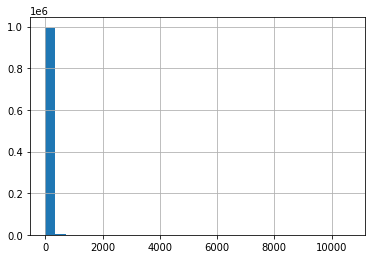

In [34]:
df_fraude['distance_from_home'].hist(bins=30)

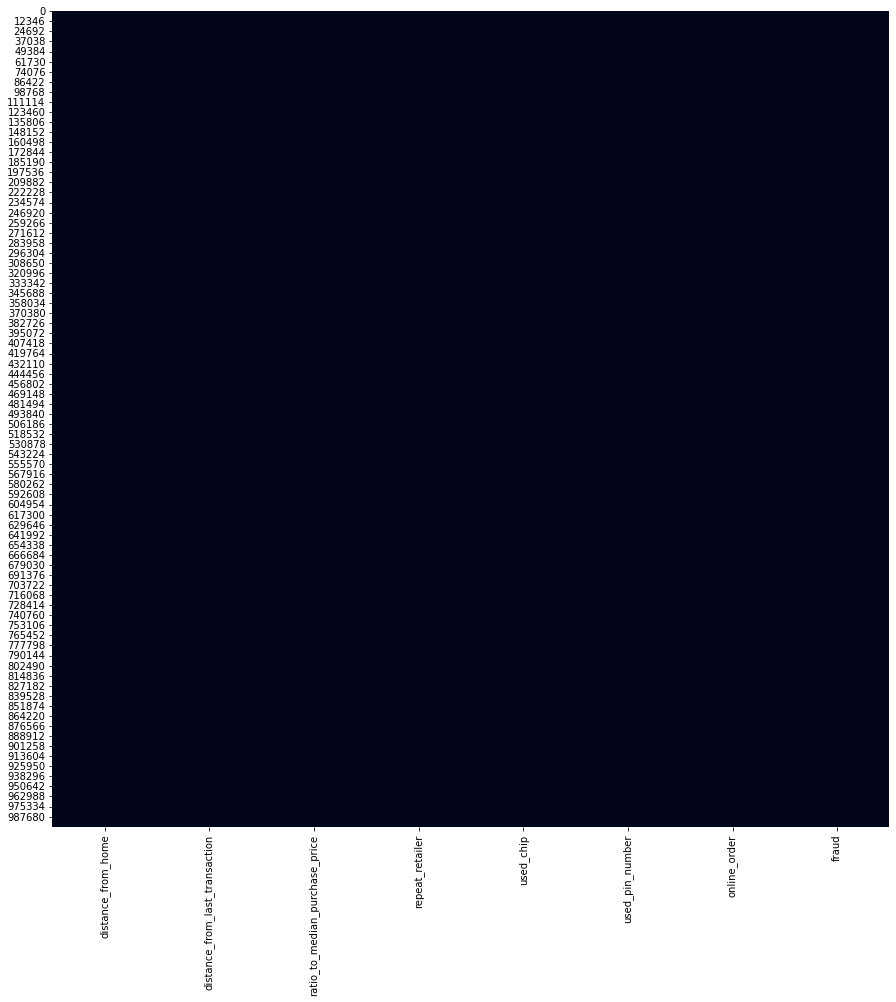

In [43]:
#Observamos graficamente los valores nulos
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_fraude.isnull(), cbar=False)
plt.show()

Se puede observar que el dataframe no tiene nulos

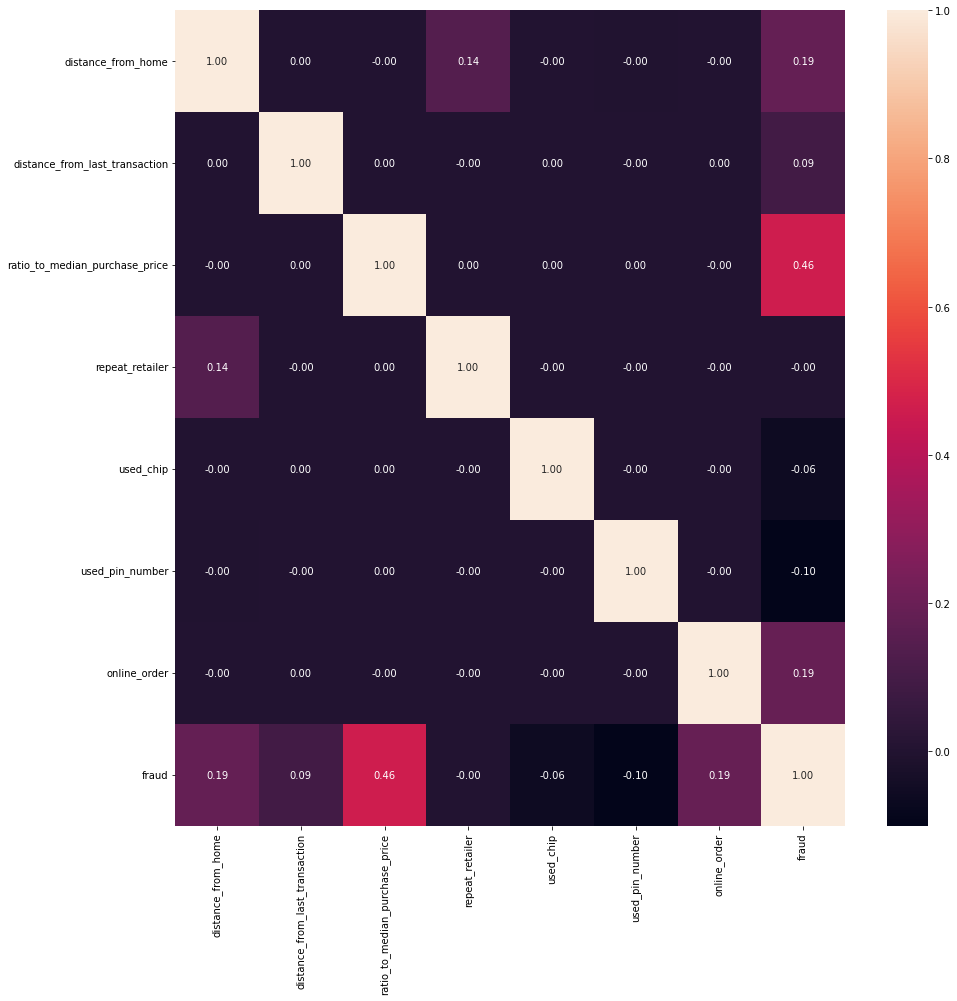

In [37]:
#graficamos el heatmap de la matriz de correlacion
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_fraude.corr(), cbar=True, annot=True, fmt='.2f')
plt.show()

In [38]:
df_fraude.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


### Este es un problema de clasificacion asi que veremos el rendimiento del modelo RandomForestClassifier

In [39]:
#creamos el dataframe de features que vamos a utilizar y el de target
X = df_fraude[['distance_from_home','ratio_to_median_purchase_price','online_order']]
y = df_fraude['fraud']

In [40]:
#creamos los grupos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [41]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)

In [48]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.97144
AUC score: 92.00503953272487


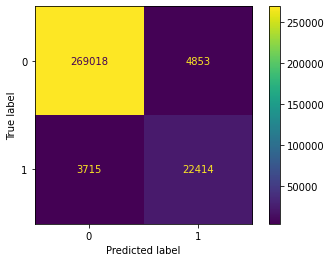

In [46]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()